## Defined Function for Image Processing (Converting to RGB Image)

In [ ]:
!nvidia-smi

Sun Mar 23 15:44:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU configured successfully")
    except RuntimeError as e:
        print(e)

GPU configured successfully


In [1]:
from google.colab import files

# Upload Kaggle API key file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chintanvdprashanth","key":"01c18e8bddcf8122c074a18946b18be5"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the API key

In [3]:
!kaggle datasets download -d sudarshanvaidya/corrective-reannotation-of-fer-ck-kdef

Dataset URL: https://www.kaggle.com/datasets/sudarshanvaidya/corrective-reannotation-of-fer-ck-kdef
License(s): unknown


In [4]:
import zipfile

dataset_path = "/content/corrective-reannotation-of-fer-ck-kdef.zip"
extract_path = "/content/fer_ck_kdef/"

with zipfile.ZipFile(dataset_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Download & extraction complete!")

Download & extraction complete!


In [37]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(image):
    image = np.array(image, dtype=np.uint8)

    # Apply CLAHE (local contrast enhancement)
    blurred = cv2.GaussianBlur(image, (3, 3), 0)

    # Normalize to [0,1] range
    normalized = blurred.astype(np.float32) / 255.0

    return normalized

## Data Loading Along with Real-time Processing

In [38]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    "/content/fer_ck_kdef/fer_ckplus_kdef/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    "/content/fer_ck_kdef/fer_ckplus_kdef/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

# test_generator = test_datagen.flow_from_directory(
#     "path_to_test_data",
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode="categorical",
#     shuffle=False
# )

Found 26286 images belonging to 8 classes.
Found 6568 images belonging to 8 classes.


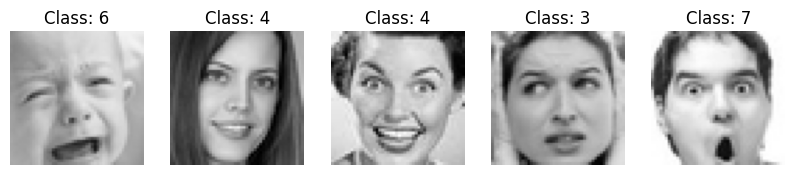

In [42]:
import matplotlib.pyplot as plt
import numpy as np

batch_images, batch_labels = next(val_generator)
# print(batch_images)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch_images[i])
    plt.axis("off")
    plt.title(f"Class: {np.argmax(batch_labels[i])}")
plt.show()

In [1]:
# Print the class index mapping from ImageDataGenerator
print(train_generator.class_indices)

NameError: name 'train_generator' is not defined

## Self Defined Loss Function (Focal Loss)

In [44]:
class FocalLoss(tf.keras.losses.Loss):
  def __init__(self, alpha=0.25, gamma=2.0, reduction=tf.keras.losses.Reduction.AUTO, name="focal_loss"):
    super().__init__(name=name,reduction=reduction)
    self.alpha = alpha
    self.gamma = gamma
    self.eps = 1e-7

  def focal_loss(self,target,output):
    """
    `FL(p_t) = alpha * (1 - p_t) ** gamma * CategoricalCE(y_true, y_pred)`
    """
    output = tf.clip_by_value(output, self.eps, 1.0 - self.eps)

    cce = -target * tf.math.log(output)

    modulating_factor = tf.pow(1.0 - output,self.gamma)
    weighting_factor = self.alpha * modulating_factor

    loss = weighting_factor * cce

    return tf.reduce_sum(loss, axis=-1)

  def call(self,y_true,y_pred):
    return self.focal_loss(y_true,y_pred)

In [45]:
# compute class weights used to handle imbalanced data.
import os
from sklearn.utils.class_weight import compute_class_weight

dataset_path = "./fer_ck_kdef/fer_ckplus_kdef/"

class_names = sorted(os.listdir(dataset_path))
print("Class Names:", class_names)

class_counts = {class_name: len(os.listdir(os.path.join(dataset_path, class_name)))
                for class_name in class_names}

class_indices = {class_name: i for i, class_name in enumerate(class_names)}

all_labels = []
for class_name, count in class_counts.items():
    all_labels.extend([class_indices[class_name]] * count)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}

Class Names: ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutrality', 'sadness', 'surprise']


In [46]:
print("Class Weights:", class_weight_dict)

Class Weights: {0: np.float64(0.8691534391534391), 1: np.float64(31.590384615384615), 2: np.float64(5.165723270440251), 3: np.float64(1.1889837869137232), 4: np.float64(0.45383467786495746), 5: np.float64(0.8096904574132492), 6: np.float64(0.7600869887099759), 7: np.float64(0.9717818267865594)}


In [47]:
max_weight = 10
class_weight_dict = {k:np.clip(v,0.5,10) for k,v in class_weight_dict.items()}
class_weights = np.clip(class_weights,0.5,10)

In [48]:
# Object for FocalLoss
focalLoss = FocalLoss(
    alpha = class_weights,
    reduction = 'sum_over_batch_size'
)

## Model Building

In [ ]:
# STEP-1 : Get the pretrained model
# from keras.applications import ResNet50

# base_model = ResNet50(include_top=False, weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# STEP-2 : Phase1 -> Addition of Fully Connected Network to base_model and Freezing base_model for training
# from keras.layers import Input, Dense, Dropout, GlobalMaxPooling2D, Flatten
# from keras.models import Model

# base_model.trainable = False

# set_trainable = False

# for layer in base_model.layers:
#     if "conv4" in layer.name or "conv5" in layer.name:
#         set_trainable = True
#     else:
#       set_trainable = False

#     if set_trainable:
#         if isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = False
#         else:
#             layer.trainable = True

# inputs = Input(shape=(224,224,3))
# conv base ResNet50

# conv_base_outs = base_model(inputs,training = False)
# flatten = GlobalMaxPooling2D()(conv_base_outs)

# Fully Connected Network.
# dense_1 = Dense(512,activation='relu')(flatten)
# dropout_1 = Dropout(0.3)(dense_1)

# dense_2 = Dense(256,activation='relu')(dropout_1)
# dropout_2 = Dropout(0.2)(dense_2)

# outputs = Dense(8,activation='softmax')(dropout_1)

# model = Model(inputs=inputs,outputs=outputs)

In [ ]:
# model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalFocalCrossentropy(
#     alpha=class_weights,
#     gamma=2.0,
#     from_logits=False,
#     label_smoothing=0.0,
#     axis=-1,
#     reduction='sum_over_batch_size',
#     name='categorical_focal_crossentropy'
# ),metrics=['accuracy'])

In [ ]:
# training the model
# history = model.fit(train_generator,epochs=10,validation_data=val_generator)

In [ ]:
# STEP-3 : Phase2 -> Model Fine Tuing (low learning rate)

# set_trainable = False

# for layer in base_model.layers:
    # Check if the layer belongs to conv4_x or conv5_x
    # if "conv4" in layer.name or "conv5" in layer.name:
    #     set_trainable = True

    # if set_trainable:
    #     if isinstance(layer, tf.keras.layers.BatchNormalization):
    #         layer.trainable = False
    #     else:
    #         layer.trainable = True

# re-build for fine-tuning.

# inputs = Input(shape=(224,224,3))
# conv base ResNet50
# conv_base_outs = base_model(inputs,training = False)
# flatten = GlobalMaxPooling2D(conv_base_outs)
# Fully Connected Network.
# dense_1 = Dense(512,activation='swish')(flatten)
# dropout_1 = Dropout(0.3)(dense_1)

# dense_2 = Dense(256,activation='swish')(dropout_1)
# dropout_2 = Dropout(0.2)(dense_2)

# outputs = Dense(8,activation='softmax')(dropout_2)

# model_f = Model(inputs=inputs,outputs=outputs)

In [ ]:
# model_f.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss=focalLoss,metrics=['accuracy'])

In [ ]:
# model.fit(train_generator,epochs=15,validation_data=val_generator,callbacks=[checkpoint])

In [49]:
# call back to save best model based on val_accuracy.
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "/contet/modelv2_obtained_finetuning.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

In [ ]:
!pip install keras_tuner

In [55]:
import keras_tuner as kt
from keras.layers import Input, Dense, Dropout, GlobalMaxPooling2D, Flatten
from keras.models import Model

def build_fcn_model(hp):
    base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        if "conv4" in layer.name or "conv5" in layer.name:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True
        else:
            layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(hp.Int("units1", min_value=128, max_value=1024, step=128), activation="swish")(x)
    x = Dropout(hp.Float("dropout1", min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(hp.Int("units2", min_value=64, max_value=512, step=64), activation="swish")(x)
    x = Dropout(hp.Float("dropout2", min_value=0.2, max_value=0.5, step=0.1))(x)
    x = Dense(8, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5])),
        loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=class_weights),
        metrics=["accuracy"]
    )

    return model

In [56]:
tuner = kt.Hyperband(
    build_fcn_model,
    objective="val_accuracy",
    max_epochs=20,
    factor=3,
    directory="tuner_results",
    project_name="resnet50_fcn_tuning"
)

In [57]:
tuner.search(train_generator, validation_data=val_generator)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
640               |640               |units1
0.2               |0.2               |dropout1
384               |384               |units2
0.4               |0.4               |dropout2
1e-05             |1e-05             |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/822 ━━━━━━━━━━━━━━━━━━━━ 3:24:54 15s/step - accuracy: 0.1016 - loss: 2.7242 

KeyboardInterrupt: 

In [ ]:
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(train_generator, validation_data=val_generator, epochs=30,callbacks=[checkpoint])

In [ ]:
# STEP-4 : Phase3 -> Testing Model
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
best_model.save('/content/modelv2.h5')